In [ ]:
# =============================================================================
# AUTISM VARIANT CLASSIFIER
# =============================================================================

import os
import sys
import subprocess
import torch
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification

try:
    import pysam
except ImportError:
    print("Installing pysam...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pysam"])
    import pysam

# Set seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# ===============================
# 1. SETUP & UTILS
# ===============================
REFERENCE_FASTA = "Homo_sapiens.GRCh38.dna.primary_assembly.fa"
MODEL_PATH = "./saved_autism_classifier"
DATA_FILENAME = "shank3_full_scan_data.csv"

def setup_genome():
    if not os.path.exists(REFERENCE_FASTA):
        print(f"Downloading reference genome: {REFERENCE_FASTA}...")
        os.system("wget -q https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz")
        os.system(f"gunzip -f Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz")
        print("Indexing genome (this may take a minute)...")
        os.system(f"samtools faidx {REFERENCE_FASTA}")

    return pysam.FastaFile(REFERENCE_FASTA)

# ===============================
# 2. TRAINING PIPELINE
# ===============================
def setup_clinvar():
    vcf_path = "clinvar.vcf.gz"
    if not os.path.exists(vcf_path):
        print("Downloading ClinVar VCF...")
        os.system("wget -q https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz")
        os.system("wget -q https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz.tbi")

    asd_keywords = ["autism", "autistic", "autism spectrum", "phelan-mcdermid", "shank3", "intellectual disability"]
    pathogenic_rows = []
    benign_rows = []

    print(f"Scanning {vcf_path} for training data...")
    vcf = pysam.VariantFile(vcf_path)

    for record in tqdm(vcf):
        if "CLNSIG" not in record.info or "CLNDN" not in record.info:
            continue

        clnsig_str = ",".join(record.info["CLNSIG"]).lower()
        clndn_str = ",".join(record.info["CLNDN"]).lower()

        # PATHOGENIC (Strict ASD/NDD filter)
        if "pathogenic" in clnsig_str and "benign" not in clnsig_str:
            if any(k in clndn_str for k in asd_keywords):
                pathogenic_rows.append({
                    "chrom": record.chrom,
                    "pos": record.pos,
                    "label": 1
                })

        # BENIGN (Broad filter for controls)
        elif "benign" in clnsig_str and "pathogenic" not in clnsig_str:
            benign_rows.append({
                "chrom": record.chrom,
                "pos": record.pos,
                "label": 0
            })

    print(f"Total ASD Pathogenic found: {len(pathogenic_rows)}")
    print(f"Total Benign controls found: {len(benign_rows)}")

    # Balance Dataset
    target_count = len(pathogenic_rows)
    if len(benign_rows) > target_count:
        print(f"Downsampling Benign variants to match Pathogenic count ({target_count})...")
        benign_rows = random.sample(benign_rows, target_count)

    all_rows = pathogenic_rows + benign_rows
    random.shuffle(all_rows)
    return pd.DataFrame(all_rows)

def get_training_window(ref_fa, chrom, pos, window=512):
    # Normalize chrom names
    chrom = str(chrom)
    chrom_clean = chrom.replace("chr", "")

    target_chrom = None
    if chrom in ref_fa.references: target_chrom = chrom
    elif chrom_clean in ref_fa.references: target_chrom = chrom_clean
    elif chrom_clean == "M" and "MT" in ref_fa.references: target_chrom = "MT"
    elif chrom_clean == "MT" and "M" in ref_fa.references: target_chrom = "M"

    if not target_chrom: return None

    half = window // 2
    start = max(0, int(pos) - 1 - half)
    end = start + window

    try:
        seq = ref_fa.fetch(target_chrom, start, end)
    except ValueError:
        return None

    if len(seq) < window:
        seq = seq + "N" * (window - len(seq))
    return seq.upper()

class DNADataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_len=512):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.sequences)
    def __getitem__(self, item):
        seq = self.sequences[item]
        label = self.labels[item]
        encoding = self.tokenizer(
            seq, return_tensors="pt", max_length=self.max_len,
            padding="max_length", truncation=True
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

def train_and_save_model(ref_fa):
    print("\n" + "="*40)
    print("STARTING MODEL TRAINING")
    print("="*40)

    # 1. Prepare Data
    clinvar_df = setup_clinvar()
    if len(clinvar_df) == 0:
        print("No training data found.")
        return None, None

    # Extract sequences
    seqs = []
    print("Extracting genomic sequences for training...")
    for idx, row in tqdm(clinvar_df.iterrows(), total=len(clinvar_df)):
        seq = get_training_window(ref_fa, row["chrom"], row["pos"])
        seqs.append(seq)

    clinvar_df["seq"] = seqs
    clinvar_df = clinvar_df.dropna(subset=["seq"])

    X = clinvar_df["seq"].tolist()
    y = clinvar_df["label"].tolist()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
    print(f"Train Set: {len(X_train)} | Test Set: {len(X_test)}")

    # 2. Setup Model
    model_name = "InstaDeepAI/nucleotide-transformer-v2-250m-multi-species"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Training on device: {device}")

    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=2, trust_remote_code=True
    )
    model.to(device)

    train_dataset = DNADataset(X_train, y_train, tokenizer)
    test_dataset = DNADataset(X_test, y_test, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8)

    optimizer = AdamW(model.parameters(), lr=2e-5)
    EPOCHS = 3

    # 3. Training Loop
    print(f"\nFine-tuning for {EPOCHS} epochs...")
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

    # 4. Evaluation
    print("\nEvaluating...")
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)
            preds.extend(predictions.cpu().numpy())
            true_labels.extend(batch["labels"].cpu().numpy())

    acc = accuracy_score(true_labels, preds)
    print(f"FINAL ACCURACY: {acc*100:.2f}%")

    # 5. Save
    print(f"Saving model to {MODEL_PATH}...")
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    model.save_pretrained(MODEL_PATH)
    tokenizer.save_pretrained(MODEL_PATH)
    print("Model saved successfully.")

    return model, tokenizer

# ===============================
# 3. INFERENCE UTILS
# ===============================
def load_saved_model():
    """Loads the model and tokenizer from disk."""
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"Saved model not found at {MODEL_PATH}. Please run with TRAIN_MODEL=True first!")

    print(f"Loading model architecture from Hub and weights from {MODEL_PATH}...")

    # 1. Define Base Model Name
    base_model_name = "InstaDeepAI/nucleotide-transformer-v2-250m-multi-species"

    # 2. Load Tokenizer & Architecture from Hub
    try:
        tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
        model = AutoModelForSequenceClassification.from_pretrained(
            base_model_name,
            num_labels=2,
            trust_remote_code=True
        )
    except Exception as e:
        print(f"Error fetching base architecture: {e}")
        raise

    # 3. Load Fine-Tuned Weights from Local Disk
    safetensors_path = os.path.join(MODEL_PATH, "model.safetensors")
    bin_path = os.path.join(MODEL_PATH, "pytorch_model.bin")

    if os.path.exists(safetensors_path):
        from safetensors.torch import load_file
        state_dict = load_file(safetensors_path)
    elif os.path.exists(bin_path):
        state_dict = torch.load(bin_path, map_location="cpu")
    else:
        raise FileNotFoundError(f"No weights file found in {MODEL_PATH}")

    # 4. Overwrite base weights
    print("Applying fine-tuned weights...")
    model.load_state_dict(state_dict)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Model loaded on {device}")
    model.to(device)
    model.eval()
    return model, tokenizer

# ==========================================
# 4. FULL GENE MUTAGENESIS (RUN & SAVE)
# ==========================================
def run_full_scan(model, tokenizer, ref_fa):
    print("\n" + "="*50)
    print("STARTING FULL SHANK3 GENE MUTAGENESIS (~60kb)")
    print("OPTIMIZED MODE: Using Mixed Precision & Large Batches")
    print("="*50)

    # Full SHANK3 Coordinates (hg38)
    TARGET_CHROM = "22"
    TARGET_START = 50672823
    TARGET_END =   50733212
    GENE_NAME = "SHANK3 (Full Gene)"

    # Fetch WT sequence
    try:
        wt_seq = ref_fa.fetch(TARGET_CHROM, TARGET_START, TARGET_END).upper()
    except KeyError:
        wt_seq = ref_fa.fetch(f"chr{TARGET_CHROM}", TARGET_START, TARGET_END).upper()

    print(f"Sequence Length: {len(wt_seq)} bp")
    print("Generating variants...")

    # Generator function
    def variant_generator(seq):
        bases = ['A', 'C', 'G', 'T']
        for i, ref_base in enumerate(seq):
            for alt_base in bases:
                if ref_base == alt_base: continue
                # Context Window: 256bp left and right
                start_context = max(0, i - 256)
                end_context = min(len(seq), i + 256)
                local_seq = list(seq[start_context:end_context])
                rel_pos = i - start_context
                local_seq[rel_pos] = alt_base
                yield {
                    "pos_idx": i,
                    "ref": ref_base,
                    "alt": alt_base,
                    "seq": "".join(local_seq)
                }

    BATCH_SIZE = 512
    variants_buffer = []
    results = []
    total_variants = len(wt_seq) * 3

    print(f"Running Inference with Batch Size {BATCH_SIZE}...")
    device = model.device
    use_amp = torch.cuda.is_available()

    with torch.no_grad():
        progress_bar = tqdm(variant_generator(wt_seq), total=total_variants)
        for variant in progress_bar:
            variants_buffer.append(variant)
            if len(variants_buffer) >= BATCH_SIZE:
                batch_seqs = [v["seq"] for v in variants_buffer]
                inputs = tokenizer(batch_seqs, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
                inputs = {k: v.to(device) for k, v in inputs.items()}

                if use_amp:
                    with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                        outputs = model(**inputs)
                else:
                    outputs = model(**inputs)

                probs = torch.softmax(outputs.logits, dim=-1)[:, 1].cpu().numpy()
                for v, score in zip(variants_buffer, probs):
                    results.append([v["pos_idx"], v["alt"], score])
                variants_buffer = []

        if variants_buffer:
            batch_seqs = [v["seq"] for v in variants_buffer]
            inputs = tokenizer(batch_seqs, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            if use_amp:
                with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(**inputs)
            else:
                outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)[:, 1].cpu().numpy()
            for v, score in zip(variants_buffer, probs):
                results.append([v["pos_idx"], v["alt"], score])

    print("\nInference complete. Building DataFrame...")
    mut_df = pd.DataFrame(results, columns=["pos_idx", "alt", "pathogenicity_score"])
    print(f"Saving inference results to {DATA_FILENAME}...")
    mut_df.to_csv(DATA_FILENAME, index=False)

    return mut_df, wt_seq, TARGET_START

# ==========================================
# 5. PLOTTING UTILS
# ==========================================
def load_previous_scan(ref_fa):
    if not os.path.exists(DATA_FILENAME):
        raise FileNotFoundError(f"{DATA_FILENAME} not found. You must run the inference at least once.")

    print(f"Loading results from {DATA_FILENAME}...")
    mut_df = pd.read_csv(DATA_FILENAME)

    TARGET_CHROM = "22"
    TARGET_START = 50672823
    TARGET_END =   50733212
    try:
        wt_seq = ref_fa.fetch(TARGET_CHROM, TARGET_START, TARGET_END).upper()
    except KeyError:
        wt_seq = ref_fa.fetch(f"chr{TARGET_CHROM}", TARGET_START, TARGET_END).upper()

    return mut_df, wt_seq, TARGET_START

def plot_full_heatmap(mut_df, wt_seq, start_coord):
    print("Generating High-Res Heatmap with coordinates...")

    heatmap_data = mut_df.pivot(index="alt", columns="pos_idx", values="pathogenicity_score")
    heatmap_data = heatmap_data.reindex(['A', 'C', 'G', 'T'])

    TICK_INTERVAL = 1000
    total_length = len(wt_seq)
    tick_positions = np.arange(0, total_length, TICK_INTERVAL)
    tick_labels = [f"{int(pos/1000)}k" for pos in tick_positions]

    plt.figure(figsize=(100, 12))
    sns.set_context("notebook", font_scale=1.5)

    ax = sns.heatmap(
        heatmap_data,
        cmap="RdYlBu_r",
        cbar_kws={'label': 'Pathogenicity Probability'},
        yticklabels=True,
        xticklabels=False,
        rasterized=True
    )

    ax.set_xticks(tick_positions + 0.5)
    ax.set_xticklabels(tick_labels, rotation=0, fontsize=16)

    # SAM Domain Label
    sam_genomic_start = 50732750
    sam_genomic_end = 50733050
    if start_coord <= sam_genomic_start:
        sam_rel_start = sam_genomic_start - start_coord
        sam_rel_end = sam_genomic_end - start_coord
        plt.plot([sam_rel_start, sam_rel_end], [-0.3, -0.3], color='black', linewidth=10, clip_on=False)
        plt.text((sam_rel_start + sam_rel_end)/2, -1.0, "SAM Domain",
                 ha='center', va='bottom', fontsize=26, fontweight='bold', color='black')

    plt.xlabel(f"Relative Position (kb) | Genomic Start: chr22:{start_coord}", fontsize=20, labelpad=20)
    plt.ylabel("Mutation To", fontsize=20)
    plt.title("Full SHANK3 Gene In Silico Mutagenesis (~60kb)", fontsize=30, pad=20)

    output_file = "shank3_FULL_gene_map_with_coords.png"
    print(f"Saving to {output_file}... (Download to zoom in)")
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print("Done!")

# ===============================
# MAIN
# ===============================
if __name__ == "__main__":
    # --- CONFIGURATION ---
    TRAIN_MODEL = False
    RUN_INFERENCE = True

    # 1. Load Genome Resource
    ref_fa = setup_genome()

    trained_model = None
    tokenizer = None

    # 2. Train (if requested)
    if TRAIN_MODEL:
        trained_model, tokenizer = train_and_save_model(ref_fa)

    # 3. Inference (Full Scan)
    if RUN_INFERENCE:
        if trained_model is None:
            # Try loading if we didn't just train it
            trained_model, tokenizer = load_saved_model()

        mut_results, wt_seq, start_coord = run_full_scan(trained_model, tokenizer, ref_fa)
    else:
        # Load from CSV (if inference already ran previously)
        mut_results, wt_seq, start_coord = load_previous_scan(ref_fa)

    # 4. Plot
    plot_full_heatmap(mut_results, wt_seq, start_coord)

Loading data from shank3_full_scan_data.csv...
Fixing data types...
Fetching reference sequence for coordinates...
Generating Heatmap...
Saving to shank3_FULL_gene_map_with_coords.png... (Download to zoom in)
Done!


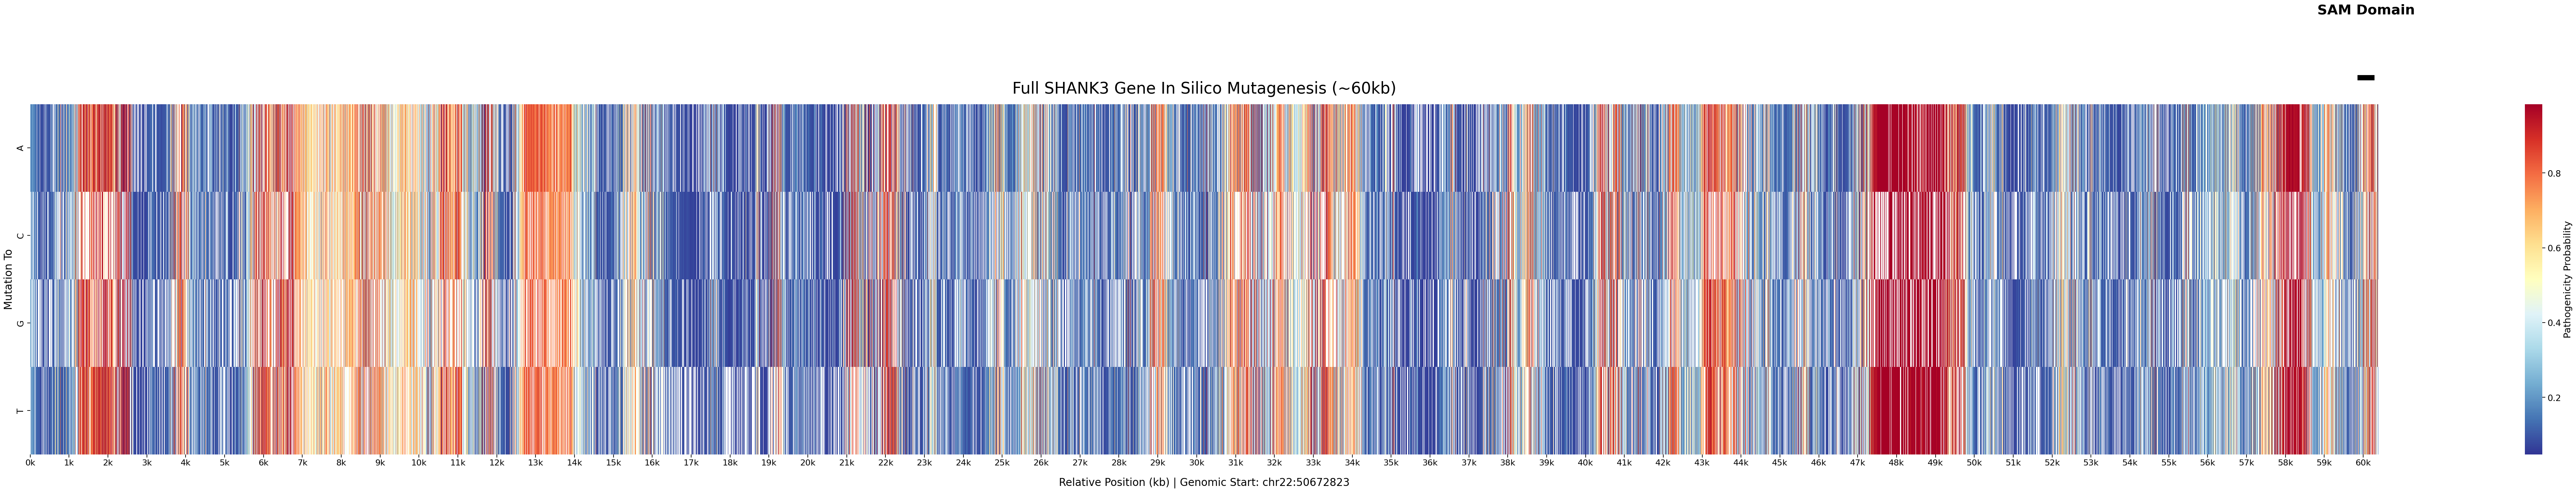

In [ ]:
# =============================================================================
# SHANK3 PLOTTING FIX (Use this if the previous script crashed during plotting)
# =============================================================================

import os
import sys
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
try:
    import pysam
except ImportError:
    print("Installing pysam...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pysam"])
    import pysam

REFERENCE_FASTA = "Homo_sapiens.GRCh38.dna.primary_assembly.fa"
DATA_FILENAME = "shank3_full_scan_data.csv"

def setup_genome():
    if not os.path.exists(REFERENCE_FASTA):
        print(f"Downloading reference genome: {REFERENCE_FASTA}...")
        os.system("wget -q https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz")
        os.system(f"gunzip -f Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz")
        os.system(f"samtools faidx {REFERENCE_FASTA}")
    return pysam.FastaFile(REFERENCE_FASTA)

def plot_safe(ref_fa):
    if not os.path.exists(DATA_FILENAME):
        print(f"Error: {DATA_FILENAME} not found.")
        print("Please check if the previous run actually reached the saving step.")
        return

    print(f"Loading data from {DATA_FILENAME}...")
    mut_df = pd.read_csv(DATA_FILENAME)
    print("Fixing data types...")
    mut_df["pos_idx"] = mut_df["pos_idx"].astype(int)
    mut_df["pathogenicity_score"] = mut_df["pathogenicity_score"].astype(float)

    if mut_df.duplicated(subset=['alt', 'pos_idx']).any():
        print("Removing duplicate entries...")
        mut_df = mut_df.drop_duplicates(subset=['alt', 'pos_idx'])

    TARGET_CHROM = "22"
    TARGET_START = 50672823
    TARGET_END =   50733212

    print("Fetching reference sequence for coordinates...")
    try:
        wt_seq = ref_fa.fetch(TARGET_CHROM, TARGET_START, TARGET_END).upper()
    except KeyError:
        wt_seq = ref_fa.fetch(f"chr{TARGET_CHROM}", TARGET_START, TARGET_END).upper()

    print("Generating Heatmap...")
    heatmap_data = mut_df.pivot(index="alt", columns="pos_idx", values="pathogenicity_score")
    heatmap_data = heatmap_data.reindex(['A', 'C', 'G', 'T'])

    TICK_INTERVAL = 1000
    total_length = len(wt_seq)
    tick_positions = np.arange(0, total_length, TICK_INTERVAL)
    tick_labels = [f"{int(pos/1000)}k" for pos in tick_positions]

    plt.figure(figsize=(100, 12))
    sns.set_context("notebook", font_scale=1.5)

    ax = sns.heatmap(
        heatmap_data,
        cmap="RdYlBu_r",
        cbar_kws={'label': 'Pathogenicity Probability'},
        yticklabels=True,
        xticklabels=False,
        rasterized=True
    )

    ax.set_xticks(tick_positions + 0.5)
    ax.set_xticklabels(tick_labels, rotation=0, fontsize=16)

    sam_genomic_start = 50732750
    sam_genomic_end = 50733050

    start_coord = TARGET_START
    if start_coord <= sam_genomic_start:
        sam_rel_start = sam_genomic_start - start_coord
        sam_rel_end = sam_genomic_end - start_coord
        plt.plot([sam_rel_start, sam_rel_end], [-0.3, -0.3], color='black', linewidth=10, clip_on=False)
        plt.text((sam_rel_start + sam_rel_end)/2, -1.0, "SAM Domain",
                 ha='center', va='bottom', fontsize=26, fontweight='bold', color='black')

    plt.xlabel(f"Relative Position (kb) | Genomic Start: chr22:{start_coord}", fontsize=20, labelpad=20)
    plt.ylabel("Mutation To", fontsize=20)
    plt.title("Full SHANK3 Gene In Silico Mutagenesis (~60kb)", fontsize=30, pad=20)

    output_file = "shank3_FULL_gene_map_with_coords.png"
    print(f"Saving to {output_file}... (Download to zoom in)")
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print("Done!")

if __name__ == "__main__":
    ref = setup_genome()
    plot_safe(ref)